## Initial setup and file reading
testing is using a local copy of the file.

In [26]:
import pandas as pd
import ebcdic
import codecs

file = r'C:\PublicData\Texas\TXRRC\index\dbf900.ebc' ##Local storage location
##file origin: ftp://ftpe.rrc.texas.gov/shfwba/dbf900.ebc.gz

with open(file, 'rb') as ebcdic:
    data = ebcdic.read()

ascii_txt = codecs.decode(data, 'cp1140')

## Splitting records into managable records to do work on them
Need to verify this is most efficent method

In [37]:
split_records = []
n  = 247 ##Unknown if this holds true for all versions of this file or for other files on TXRRC

for index in range(0, len(ascii_txt), n):
    split_records.append(ascii_txt[index : index + n])

## Testing the record order and formatting

In [33]:
API = None
for record in split_records[0:100]:
    if record.startswith('01'):
        ct+=1
        API = record[2:10]
        print('---------------------------------------------------')
        print(API, ' Starting')
    print(API, record[0:2])
    print(record)
    print('---')

---------------------------------------------------
00100001  Starting
00100001 01
0100100001010106001 19631027000000000000000000000000000 000000000010000100000000000000  NNN00000000Y0 13A19930900000019931022199602L0040230000000199801000000Y 00000000                                                                                
---
00100001 02
02O0604411   1  00      000000000000000000000                                          0000000000000000000000000000000000N0000000     00000          0000  NN00000000                                                                                  
---
00100001 03
038015988719840112        NNNNN1963120519631027000000000000000000      00000        N0000  00000000                                                                                                                                                    
---
00100001 06
0600100000000000000000000000000000S000000        0000000000000000000000000000000000000000000000000000000                     

### Checking number of well records in the file. These may be inaccurate with multiple well bore with the same API8 used by TXRRC

In [35]:
API = None
APIs =[]
ct = 0
for record in split_records:
    if record.startswith('01'):
        ct+=1
        APIs.append(record[2:10])

In [36]:
print(ct, len(APIs))

1163117 1163117


## Start of record definition layout. Names from the manual.
#### Definitions from https://www.rrc.texas.gov/media/41906/wba091_well-bore-database.pdf
Notes for where the definition sheet was modified to better suite new formatting (e.g. date formats)

Each items has (Name, Starting character in record, number of characters after start, format)
Note that format type is borrowed from  skylerbast/TxRRC_data and may not be appropriate for JSON or MySQL storage

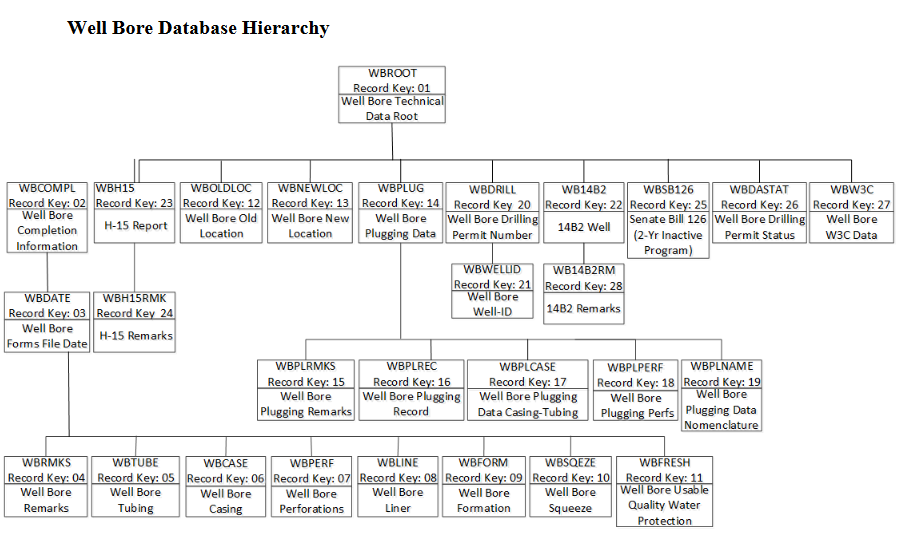

### First draft of definition sections for testing.

#### Format types
- pic_any - string<br>
- pic_numeric - whole numbers (interger)<br>
- pic_yyyymmdd - date in YYYYMMDD format<br>
- pic_yyyymm - date in YYYYMM format<br>
- pic_latlong - numbers in DDDDDDDDD format, need to be separated and converted to DDD.DDDDDD<br> 
- pic_coord - numbers in CCCCCCCCC format, need to be separated and convered to CCCCCCCC.C<br>

more types may need to be defined later

In [5]:
WBROOT_01 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WELL-BORE-API-ROOT',2,8,'pic_numeric'), ## Combines WB-API-CNTY and WB-API-UNIQUE
            ('WB-NXT-AVAIL-SUFFIX',10,2,'pic_numeric'),
            ('WB-NXT-AVAIL-HOLE-CHGE-NBR',12,2,'pic_numeric'),
            ('WB-FIELD-DISTRICT',14,2,'pic_numeric'),
            ('WB-RES-CNTY-CODE',16,3,'pic_numeric'),
            ('WB-ORIG-COMPL-DATE',20,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-ORIG-COMPL-CENT&YY&MM&DD
            ('WB-TOTAL-DEPTH',28,5,'pic_numeric'),
            ('WB-VALID-FLUID-LEVEL',33,5,'pic_numeric'),
            ('WB-CERTIFICATION-REVOKED-DATE',38,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-CERT-REVOKED-CC&YY&MM&DD
            ('WB-CERTIFICATION-DENIAL-DATE',46,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-CERTIFICATION-DENIAL-CC&YY&MM&DD
            ('WB-DENIAL-REASON-FLAG',56,1,'pic_any'),
            ('WB-ERROR-API-ASSIGN-CODE',55,1,'pic_any'),
            ('WB-REFER-CORRECT-API-NBR',56,8,'pic_numeric'),
            ('WB-DUMMY-API-NUMBER',64,8,'pic_numeric'),
            ('WB-DATE-DUMMY-REPLACED',72,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-NEWEST-DRL-PMT-NBR',80,6,'pic_numeric'),
            ('WB-CANCEL-EXPIRE-CODE',86,1,'pic_any'),
            ('WB-EXCEPT-13-A',88,1,'pic_any'),
            ('WB-FRESH-WATER-FLAG',89,1,'pic_any'),
            ('WB-PLUG-FLAG',90,1,'pic_any'),
            ('WB-PREVIOUS-API-NBR',91,8,'pic_numeric'),
            ('WB-COMPLETION-DATA-IND',99,1,'pic_any'),
            ('WB-HIST-DATE-SOURCE-FLAG',100,1,'pic_numeric'),
            ('WB-EX14B2-COUNT',102,2,'pic_numeric'),
            ('WB-DESIGNATION-HB-1975-FLAG',104,1,'pic_any'),
            ('WB-DESIGNATION-EFFECTIVE-DATE',105,6,'pic_yyyymm'), ##YYYYMM Combines WB-DESIGNATION-EFFEC-CC&YY&MM
            ('WB-DESIGNATION-REVISED-DATE',111,6,'pic_yyyymm'), ##YYYYMM Combines WB-DESIGNATION-REVISED-CC&YY&MM
            ('WB-DESIGNATION-LETTER-DATE',117,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-DESIGNATION-LETTER-CC&YY&MM&DD
            ('WB-CERTIFICATION-EFFECT-DATE',125,6,'pic_yyyymm'), ##YYYYMM Combines WB-CERTIFICATION-EFFEC-CC&YY&MM
            ('WB-WATER-LAND-CODE',131,1,'pic_any'),
            ('WB-TOTAL-BONDED-DEPTH',132,6,'pic_numeric'),
            ('WB-OVERRIDE-EST-PLUG-COST',138,7,'pic_numeric'),
            ('WB-SHUT-IN-DATE',145,6,'pic_numeric'), ##YYYYMM
            ('WB-OVERRIDE-BONDED-DEPTH',151,6,'pic_numeric'),
            ('WB-SUBJ-TO-14B2-FLAG',157,1,'pic_any'),
            ('WB-PEND-REMOVAL-14B2-FLAG',158,1,'pic_any'),
            ('WB-ORPHAN-WELL-HOLD-FLAG',159,1,'pic_any'),
            ('WB-W3X-WELL-FLAG',160,1,'pic_any')
            ]

WBCOMPL_02oil =[
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-OIL-CODE',2,1,'pic_any'), ##If gas use WBCOMPL_02gas
            ('WB-OIL-DIST',3,2,'pic_numeric'), ##If gas use WBCOMPL_02gas
            ('WB-OIL-LSE-NBR',5,5,'pic_numeric'), ##If gas use WBCOMPL_02gas
            ('WB-OIL-WELL-NBR',10,6,'pic_any'), ##If gas use WBCOMPL_02gas
            ('WB-GAS-DIST',16,2,'pic_numeric'),
            ('WB-GAS-WELL-NO',18,6,'pic_any'),
            ('WB-MULTI-WELL-REC-NBR',24,1,'pic_any'),
            ('WB-API-SUFFIX',25,2,'pic_numeric'),
            ('WB-ACTIVE-INACTIVE-CODE',45,1,'pic_any'),
            ('WB-DWN-HOLE-COMMINGLE-CODE',86,1,'pic_any'),
            ('WB-CREATED-FROM-PI-FLAG',121,1,'pic_any'),
            ('WB-RULE-37-NBR',122,7,'pic_numeric'),
            ('WB-P-15',155,1,'pic_any'),
            ('WB-P-12',156,1,'pic_any'),
            ('WB-PLUG-DATE-POINTER',157,8,'pic_numeric')
            ]

WBCOMPL_02gas =[
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-GAS-CODE',2,1,'pic_any'), ##If oil use WBCOMPL_02oil
            ('WB-GAS-RRC-ID',3,6,'pic_numeric'), ##If oil use WBCOMPL_02oil
            ('WB-GAS-DIST',16,2,'pic_numeric'),
            ('WB-GAS-WELL-NO',18,6,'pic_any'),
            ('WB-MULTI-WELL-REC-NBR',24,1,'pic_any'),
            ('WB-API-SUFFIX',25,2,'pic_numeric'),
            ('WB-ACTIVE-INACTIVE-CODE',45,1,'pic_any'),
            ('WB-DWN-HOLE-COMMINGLE-CODE',86,1,'pic_any'),
            ('WB-CREATED-FROM-PI-FLAG',121,1,'pic_any'),
            ('WB-RULE-37-NBR',122,7,'pic_numeric'),
            ('WB-P-15',155,1,'pic_any'),
            ('WB-P-12',156,1,'pic_any'),
            ('WB-PLUG-DATE-POINTER',157,8,'pic_numeric')
            ]

WBDATE_03 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-FILE-KEY',2,8,'pic_numeric'),
            ('WB-FILE-DATE',10,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-EXCEPT-RULE-11',26,1,'pic_any'),
            ('WB-CEMENT-AFFIDAVIT',27,1,'pic_any'),
            ('WB-G-5',28,1,'pic_any'),
            ('WB-W-12',29,1,'pic_any'),
            ('WB-DIR-SURVEY',30,1,'pic_any'),
            ('WB-W2-G1-DATE ',31,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-COMPL-DATE',39,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-COMPL-CENTURY&YEAR&MONTH&DAY
            ('WB-DRL-COMPL-DATE',47,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUGB-DEPTH1',55,5,'pic_numeric'),
            ('WB-PLUGB-DEPTH2',60,5,'pic_numeric'),
            ('WB-WATER-INJECTION-NBR',65,6,'pic_any'),
            ('WB-SALT-WTR-NBR',71,5,'pic_numeric'),
            ('WB-REMARKS-IND',84,1,'pic_any'),
            ('WB-ELEVATION',85,4,'pic_numeric'),
            ('WB-ELEVATION-CODE',89,2,'pic_any'),
            ('WB-LOG-FILE-RBA',91,8,'pic_numeric'),
            ('WB-DOCKET-NBR',99,10,'pic_any'),
            ('WB-PSA-WELL-FLAG',109,1,'pic_any'),
            ('WB-ALLOCATION-WELL-FLAG',110,1,'pic_any')
            ]

WBRMKS_04 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-RMK-LNE-CNT',2,3,'pic_numeric'),
            ('WB-RMK-TYPE-CODE',5,1,'pic_any'),
            ('WB-REMARKS',6,70,'pic_any')
            ]

WBTUBE_05 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-SEGMENT-COUNTER ',2,3,'pic_numeric'),
            ('WB-TUBING-INCHES',5,2,'pic_numeric'),
            ('WB-FR-NUMERATOR',7,2,'pic_numeric'),
            ('WB-FR-DENOMINATOR',9,2,'pic_numeric'),
            ('WB-DEPTH-SET',11,5,'pic_numeric'),
            ('WB-PACKER-SET',16,5,'pic_numeric')
            ]

WBCASE_06 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-CASING-COUNT',2,3,'pic_numeric'),
            ('WB-CAS-INCH',5,2,'pic_numeric'),
            ('WB-CAS-FRAC-NUM',7,2,'pic_numeric'),
            ('WB-CAS-FRAC-DENOM',9,2,'pic_numeric'),
            ('WB-CAS-WT-TABLE',11,8,'pic_numeric'), ##ISSUE 03 WB-CASING-WEIGHT-LBS-FT REDEFINES WB-CAS-WT-TABLEOCCURS 2 TIMES.(05 WB-WGT-WHOLE PIC 9(03))(05 WB-WGT-TENTHS PIC 9(01))
            ('WB-CASING-DEPTH-SET',19,5,'pic_numeric'),
            ('WB-MLTI-STG-TOOL-DPTH',24,5,'pic_numeric'),
            ('WB-AMOUNT-OF-CEMENT',29,5,'pic_numeric'),
            ('WB-CEMENT-MEASUREMENT',34,1,'pic_any'), ##S = sacks, Y = yards, F = cubic feet
            ('WB-HOLE-INCH',35,2,'pic_numeric'),
            ('WB-HOLE-FRAC-NUM',37,2,'pic_numeric'),
            ('WB-HOLE-FRAC-DENOM',39,2,'pic_numeric'),
            ('WB-TOP-OF-CEMENT-CASING',42,7,'pic_any'),
            ('WB-AMOUNT-CASING-LEFT',49,5,'pic_numeric')
            ]

WBPERF_07 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PERF-COUNT',2,3,'pic_numeric'),
            ('WB-FROM-PERF',5,5,'pic_numeric'),
            ('WB-TO-PERF',10,5,'pic_numeric'),
            ('WB-OPEN-HOLE-CODE',15,2,'pic_any') ##WB-OPEN-HOLE VALUE 'OH'
            ]

WBLINE_08 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-LINE-COUNT',2,3,'pic_numeric'),
            ('WB-LIN-INCH',5,2,'pic_numeric'),
            ('WB-LIN-FRAC-NUM',7,2,'pic_numeric'),
            ('WB-LIN-FRAC-DENOM',9,2,'pic_numeric'),
            ('WB-SACKS-OF-CEMENT',11,5,'pic_numeric'),
            ('WB-TOP-OF-LINER',16,5,'pic_numeric'),
            ('WB-BOTTOM-OF-LINER',21,5,'pic_numeric')
            ]

WBFORM_09 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-FORMATION-CNTR',2,3,'pic_numeric'),
            ('WB-FORMATION-NAME',5,32,'pic_any'),
            ('WB-FORMATION-DEPTH',37,5,'pic_numeric')
            ]

WBSQEZE_10 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-SQUEEZE-CNTR ',2,3,'pic_numeric'),
            ('WB-SQUEEZE-UPPER-DEPTH ',5,5,'pic_numeric'),
            ('WB-SQUEEZE-LOWER-DEPTH',10,5,'pic_numeric'),
            ('WB-SQUEEZE-KIND-AMOUNT ',17,50,'pic_any')
            ]

WBFRESH_11 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-FRESH-WATER-CNTR',2,3,'pic_numeric'),
            ('WB-TWDB-DATE',5,8,'pic_numeric'), #YYYYMMDD
            ('WB-SURFACE-CASING-DETER-CODE',13,1,'pic_any'), #WB-FIELD-RULE-CODE Y or N
            ('WB-UQWP-FROM',14,4,'pic_numeric'),
            ('WB-UQWP-TO',18,4,'pic_numeric')
            ]

WBOLDLOC_12 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-LEASE-NAME',2,32,'pic_any'),
            ('WB-SEC-BLK-SURVEY-LOC',34,52,'pic_any'),
            ('WB-WELL-LOC-MILES',86,4,'pic_numeric'),
            ('WB-WELL-LOC-DIRECTION',90,6,'pic_any'),
            ('WB-WELL-LOC-NEAREST-TOWN',96,13,'pic_any'),
            ('WB-DIST-FROM-SURVEY-LINES',137,28,'pic_any'),
            ('WB-DIST-DIRECT-NEAR-WELL',165,28,'pic_any')
            ]

WBNEWLOC_13 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-LOC-COUNTY',2,3,'pic_numeric'),
            ('WB-ABSTRACT',5,6,'pic_any'),
            ('WB-SURVEY',11,55,'pic_any'),
            ('WB-BLOCK-NUMBER',66,10,'pic_any'),
            ('WB-SECTION',76,8,'pic_any'),
            ('WB-ALT-SECTION',84,4,'pic_any'),
            ('WB-ALT-ABSTRACT',88,6,'pic_any'),
            ('WB-FEET-FROM-SUR-SECT-1',94,6,'pic_numeric'),
            ('WB-DIREC-FROM-SUR-SECT-1',100,13,'pic_any'),
            ('WB-FEET-FROM-SUR-SECT-2',113,6,'pic_numeric'),
            ('WB-DIREC-FROM-SUR-SECT-2',119,13,'pic_any'),
            ('WB-WGS84-LATITUDE',132,9,'pic_latlong'), ##PIC S9(3)V9(7) ##DDD.DDDDDDD ISSUE WITH characters at end of each section
            ('WB-WGS84-LONGITUDE',142,9,'pic_latlong'), ##PIC S9(3)V9(7) ##DDD.DDDDDDD ISSUE WITH characters at end of each section
            ('WB-PLANE-ZONE',157,2,'pic_numeric'),
            ('WB-PLANE-COORDINATE-EAST',159,9,'pic_coord'), ##PIC S9(8)V9(2) TX State plane ft NAD27 DDDDDDDD.DD ISSUE WITH characters at end of each section
            ('WB-PLANE-COORDINATE-NORTH',169,9,'pic_coord'), ##PIC S9(8)V9(2) TX State plane ft NAD27 DDDDDDDD.DD ISSUE WITH characters at end of each section
            ('WB-VERIFICATION-FLAG',177,1,'pic_any') #N = not verified, Y = verified, C = verified change
            ]

WBPLUG_14oil = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-DATE-W3-FILED',2,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-DATE-WELL-BORE-PLUGGED',10,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-TOTAL-DEPTH',18,5,'pic_numeric'),
            ('WB-PLUG-CEMENT-COMP',23,32,'pic_any'),
            ('WB-PLUG-MUD-FILLED',55,1,'pic_any'),
            ('WB-PLUG-MUD-APPLIED',56,12,'pic_any'),
            ('WB-PLUG-MUD-WEIGHT',68,3,'pic_numeric'),
            ('WB-PLUG-DRIL-PERM-DATE',75,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-DRIL-PERM-NO',83,6,'pic_numeric'),
            ('WB-PLUG-DRIL-COMP-DATE',89,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-LOG-ATTACHED',97,1,'pic_any'),
            ('WB-PLUG-LOG-RELEASED-TO',98,32,'pic_any'),
            ('WB-PLUG-TYPE-LOG',130,1,'pic_any'), ##D=Drillers E=Electric R=Radioactivity A=Acoustical-sonic F=Dril-and-Elec G=Elec-and-Radio H=radio-and-acous I=Dril-and-acous J=elec-and-acous K=dril-and-acous L=dril-elec-radio M=elec-radio-acous N=Dril-elec-acous O=dril-radio-acous P=dril-elec-radio-acous
            ('WB-PLUG-FRESH-WATER-DEPTH',131,5,'pic_numeric'),
            ('WB-PLUG-UWQP',136,40,'pic_any'), ##REDEFINES  WB-PLUG-UWQP. WB-PLUG-FROM-UWQP  OCCURS 4 TIMES PIC 9(05), WB-PLUG-TO-UWQP    OCCURS 4 TIMES PIC 9(05)
            ('WB-PLUG-MATERIAL-LEFT',176,1,'pic_any'),
            ('WB-PLUG-OIL-CODE',177,1,'pic_any'), ##if gas use WBPLUG_14gas
            ('WB-PLUG-OIL-DIST',178,2,'pic_numeric'), ##if gas use WBPLUG_14gas
            ('WB-PLUG-OIL-LSE-NBR',180,5,'pic_numeric'), ##if gas use WBPLUG_14gas
            ('WB-PLUG-OIL-WELL-NBR',185,6,'pic_any'), ##if gas use WBPLUG_14gas
            ('WB-PLUG-GAS-DIST',191,2,'pic_numeric'),
            ('WB-PLUG-GAS-WELL-NO',193,6,'pic_any'),
            ('WB-PLUG-TYPE-WELL',199,1,'pic_any'), ##O=Oil, G=Gas, D=Dry, S=Service
            ('WB-PLUG-MULTI-COMPL-FLAG',200,1,'pic_any'),
            ('WB-PLUG-CEM-AFF',201,1,'pic_any'), ##Y=WB-PLUG-CA-FILED N=WB-PLUG-CA-NOT-FILED
            ('WB-PLUG-13A',202,1,'pic_any'), ##Y=WB-PLUG-13A-FILED N=WB-PLUG-13A-NOT-FILED
            ('WB-PLUG-LOG-RELEASED-DATE',203,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-LOG-FILE-RBA',211,8,'pic_numeric'),
            ('WB-STATE-FUNDED-PLUG-NUMBER',219,7,'pic_numeric')
            ]

WBPLUG_14gas = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-DATE-W3-FILED',2,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-DATE-WELL-BORE-PLUGGED',10,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-TOTAL-DEPTH',18,5,'pic_numeric'),
            ('WB-PLUG-CEMENT-COMP',23,32,'pic_any'),
            ('WB-PLUG-MUD-FILLED',55,1,'pic_any'),
            ('WB-PLUG-MUD-APPLIED',56,12,'pic_any'),
            ('WB-PLUG-MUD-WEIGHT',68,3,'pic_numeric'),
            ('WB-PLUG-DRIL-PERM-DATE',75,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-DRIL-PERM-NO',83,6,'pic_numeric'),
            ('WB-PLUG-DRIL-COMP-DATE',89,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-LOG-ATTACHED',97,1,'pic_any'),
            ('WB-PLUG-LOG-RELEASED-TO',98,32,'pic_any'),
            ('WB-PLUG-TYPE-LOG',130,1,'pic_any'), ##D=Drillers E=Electric R=Radioactivity A=Acoustical-sonic F=Dril-and-Elec G=Elec-and-Radio H=radio-and-acous I=Dril-and-acous J=elec-and-acous K=dril-and-acous L=dril-elec-radio M=elec-radio-acous N=Dril-elec-acous O=dril-radio-acous P=dril-elec-radio-acous
            ('WB-PLUG-FRESH-WATER-DEPTH',131,5,'pic_numeric'),
            ('WB-PLUG-UWQP',136,40,'pic_any'), ##REDEFINES  WB-PLUG-UWQP. WB-PLUG-FROM-UWQP  OCCURS 4 TIMES PIC 9(05), WB-PLUG-TO-UWQP    OCCURS 4 TIMES PIC 9(05)
            ('WB-PLUG-MATERIAL-LEFT',176,1,'pic_any'),
            ('WB-PLUG-GAS-CODE',177,1,'pic_any'), ##If oil use WBPLUG_14oil
            ('WB-PLUG-GAS-RRC-ID',178,6,'pic_numeric'), ##If oil use WBPLUG_14oil
            ('WB-PLUG-GAS-DIST',191,2,'pic_numeric'),
            ('WB-PLUG-GAS-WELL-NO',193,6,'pic_any'),
            ('WB-PLUG-TYPE-WELL',199,1,'pic_any'), ##O=Oil, G=Gas, D=Dry, S=Service
            ('WB-PLUG-MULTI-COMPL-FLAG',200,1,'pic_any'),
            ('WB-PLUG-CEM-AFF',201,1,'pic_any'), ##Y=WB-PLUG-CA-FILED N=WB-PLUG-CA-NOT-FILED
            ('WB-PLUG-13A',202,1,'pic_any'), ##Y=WB-PLUG-13A-FILED N=WB-PLUG-13A-NOT-FILED
            ('WB-PLUG-LOG-RELEASED-DATE',203,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-PLUG-LOG-FILE-RBA',211,8,'pic_numeric'),
            ('WB-STATE-FUNDED-PLUG-NUMBER',219,7,'pic_numeric')
            ]

WBPLRMKS_15 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PLUG-RMK-LNE-CNT',2,3,'pic_numeric'),
            ('WB-PLUG-RMK-TYPE-CODE',5,1,'pic_any'),
            ('WB-PLUG-REMARKS',6,70,'pic_any')
            ]

WBPLREC_16 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PLUG-NUMBER',2,3,'pic_numeric'),
            ('WB-NBR-OF-CEMENT-SACKS',5,5,'pic_numeric'),
            ('WB-MEAS-TOP-OF-PLUG',10,5,'pic_numeric'),
            ('WB-BOTTOM-TUBE-PIPE-DEPTH',15,5,'pic_numeric'),
            ('WB-PLUG-CALC-TOP',20,5,'pic_numeric'),
            ('WB-PLUG-TYPE-CEMENT',25,6,'pic_any')
            ]

WBPLCASE_17 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PLG-CAS-COUNTER',2,6,'pic_numeric'),
            ('WB-PLUG-CAS-INCH',8,2,'pic_numeric'),
            ('WB-PLUG-CAS-FRAC-NUM',10,2,'pic_numeric'),
            ('WB-PLUG-CAS-FRAC-DENOM',12,2,'pic_numeric'),
            ('WB-PLUG-WGT-WHOLE',14,3,'pic_numeric'),
            ('WB-PLUG-WGT-TENTHS',17,1,'pic_numeric'),
            ('WB-PLUG-AMT-PUT',18,5,'pic_numeric'),
            ('WB-PLUG-AMT-LEFT',23,5,'pic_numeric'),
            ('WB-PLUG-HOLE-INCH',28,2,'pic_numeric'),
            ('WB-PLUG-HOLE-FRAC-NUM',30,2,'pic_numeric'),
            ('WB-PLUG-HOLE-FRAC-DENOM',32,2,'pic_numeric')
            ]

WBPLPERF_18 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PLUG-PERF-COUNTER',2,3,'pic_numeric'),
            ('WB-PLUG-FROM-PERF',5,5,'pic_numeric'),
            ('WB-PLUG-TO-PERF',10,5,'pic_numeric'),
            ('WB-PLUG-OPEN-HOLE-INDICATOR',15,1,'pic_any')
            ]

WBPLNAME_19 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PLUG-FIELD-NO',2,8,'pic_numeric'),
            ('WB-PLUG-FIELD-NAME',10,32,'pic_any'),
            ('WB-PLUG-OPER-NO',42,6,'pic_any'),
            ('WB-PLUG-OPER-NAME',48,32,'pic_any'),
            ('WB-PLUG-LEASE-NAME',80,32,'pic_any')
            ]

WBDRILL_20 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-PERMIT-NUMBER',2,6,'pic_numeric')
            ]

WBWELLID_21oil = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-OIL',2,1,'pic_any'),
            ('WB-OIL-DISTRICT',3,2,'pic_numeric'),
            ('WB-OIL-LSE-NUMBER',5,5,'pic_numeric'),
            ('WB-OIL-WELL-NUMBER',10,6,'pic_any')
            ]

WBWELLID_21gas = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-GAS',2,1,'pic_any'),
            ('WB-GAS-RRCID',3,6,'pic_numeric')
            ]

WB14B2_22oil = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB14B2-OIL-CODE',2,1,'pic_any'), ##if gas use WB14B2_22gas
            ('WB14B2-OIL-DISTRICT',3,2,'pic_numeric'), ##if gas use WB14B2_22gas
            ('WB14B2-OIL-LEASE-NUMBER',5,5,'pic_numeric'), ##if gas use WB14B2_22gas
            ('WB14B2-OIL-WELL-NUMBER',10,6,'pic_any'), ##if gas use WB14B2_22gas
            ('WB14B2-APPLICATION-NUMBER',16,6,'pic_numeric'),
            ('WB14B2-GAS-DISTRICT',22,2,'pic_numeric'),
            ('WB14B2-EXT-STATUS-FLAG',24,1,'pic_any'), ##A=approved C=cancelled D=Denied E=Expired
            ('WB14B2-EXT-CANCELLED-REASON',25,1,'pic_any'), ##I=injection P=producing G=plugged S=Service O=cancelled-other
            ('WB14B2-EXT-APPROVED-DATE',26,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-APPROVED CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-EXP-DATE',34,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-EXP-CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-DENIED-DATE',42,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-DENIED-CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-HIST-DATE',50,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-HIST-CENT+YEAR+MONTH+DAY
            ('WB14B2-MECH-INTEG-VIOL-FLAG',58,1,'pic_any'),## WB14B2-MECH-INTEG-VIOL VALUE 'H'
            ('WB14B2-PLUG-ORDER-SF-HOLD-FLAG',59,1,'pic_any'), ## WB14B2-PLUG-ORDER-SF-HOLD VALUE 'E'
            ('WB14B2-POLLUTION-VIOL-FLAG',60,1,'pic_any'), ## WB14B2-POLLUTION-VIOLVALUE 'P'
            ('WB14B2-FIELD-OPS-HOLD-FLAG',61,1,'pic_any'), ## WB14B2-FIELD-OPS-HOLD VALUE 'F'
            ('WB14B2-H15-PROBLEM-FLAG',62,1,'pic_any'), ## WB14B2-H15-PROBLEM VALUE 'V'
            ('WB14B2-H15-NOT-FILED-FLAG',63,1,'pic_any'), ## WB14B2-H15-NOT-FILED VALUE 'X'
            ('WB14B2-OPER-DELQ-FLAG',64,1,'pic_any'), ## WB14B2-OPER-DELQ VALUE 'O'
            ('WB14B2-DISTRICT-HOLD-SFP-FLAG',65,1,'pic_any'), ## WB14B2-DISTRICT-HOLD-SFP VALUE 'T'
            ('WB14B2-DIST-SF-CLEAN-UP-FLAG',66,1,'pic_any'), ## WB14B2-DIST-SF-CLEAN-UP VALUE 'M'
            ('WB14B2-DIST-STATE-PLUG-FLAG',67,1,'pic_any'), ## WB14B2-DIST-STATE-PLUG VALUE 'K'
            ('WB14B2-GOOD-FAITH-VIOL-FLAG',68,1,'pic_any'), ## WB14B2-GOOD-FAITH-VIOL VALUE 'R'
            ('WB14B2-WELL-OTHER-VIOL-FLAG',69,1,'pic_any'), ## WB14B2-WELL-OTHER-VIOL VALUE 'Q'
            ('WB14B2-W3C-SURF-EQP-VIOL-FLAG',70,1,'pic_any'), ## WB14B2-W3C-SURF-EQUIP-VIOL VALUE 'S'
            ('WB14B2-W3X-VIOL-FLAG',71,1,'pic_any'), ## WB14B2-W3X-VIOL VALUE 'W'
            ('WB14B2-HB2259-W3X-PUB-ENT',79,1,'pic_any'),
            ('WB14B2-HB2259-W3X-10PCT',80,1,'pic_any'),
            ('WB14B2-HB2259-W3X-BONDING',81,1,'pic_any'),
            ('WB14B2-HB2259-W3X-H13-EOR',82,1,'pic_any'), ## WB14B2-HB2259-EOR-REJECTED VALUE 'R'
            ('WB14B2-HB2259-W3X-AOP',83,1,'pic_any'), ## WB14B2-HB2259-AOP-REJECTEDVALUE 'R'
            ('WB14B2-HB2259-W3X-MIT',84,1,'pic_any'), ## WB14B2-HB2259-MIT-REJECTED VALUE 'R'
            ('WB14B2-HB2259-W3X-ESCROW',85,1,'pic_any'), ## WB14B2-HB2259-ESCROW-REJECTED VALUE 'R'
            ('WB14B2-W3X-FILING-KEY',86,8,'pic_numeric'),
            ('WB14B2-W3X-AOP-RECEIVED-DATE',94,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-AOP-FEE-RCVD-DATE',102,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-H15-FEE-RCVD-DATE',110,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-ESCROW-FUNDS',118,5,'pic_numeric'), ##ISSUE WB14B2-W3X-ESCROW-FUNDS         VALUE ZEROS PIC 9(05)V99.119 WB14B2-W3X-ESCROW-FUND-SPLIT REDEFINESWB14B2-W3X-ESCROW-FUNDS.07 WB14B2-W3X-ESCROW-FUND-WHOLE               PIC 9(05).07 WB14B2-W3X-ESCROW-FUND-DECIMAL             PIC 9(02).
            ('WB14B2-60-DAY-LETTER-SENT-FLAG',125,1,'pic_any'),
            ('WB14B2-W1X-36-NEEDS-BOND-FLAG',126,1,'pic_any'),
            ('WB14B2-W1X-36-TYPE-COVERAGE',127,1,'pic_any'),## WB14B2-W1X-36-BOND VALUE 'B'  WB14B2-W1X-36-LOC VALUE 'L'
            ('WB14B2-W1X-36-AMT-FILED',128,9,'pic_numeric'),
            ('WB14B2-W1X-36-SURETY',137,5,'pic_numeric'),
            ('WB14B2-W1X-36-EXP-DATE',142,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-W1X-36-EXP-CENT+YEAR+MON+DAY
            ('WB14B2-W1X-36-BOND-NUMBER',150,20,'pic_any')
            ]

WB14B2_22gas = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB14B2-GAS-CODE',2,1,'pic_any'), ##if oil use WB14B2_22oil
            ('WB14B2-GAS-RRC-ID',3,6,'pic_numeric'), ##if oil use WB14B2_22oil
            ('WB14B2-APPLICATION-NUMBER',16,6,'pic_numeric'),
            ('WB14B2-GAS-DISTRICT',22,2,'pic_numeric'),
            ('WB14B2-EXT-STATUS-FLAG',24,1,'pic_any'), ##A=approved C=cancelled D=Denied E=Expired
            ('WB14B2-EXT-CANCELLED-REASON',25,1,'pic_any'), ##I=injection P=producing G=plugged S=Service O=cancelled-other
            ('WB14B2-EXT-APPROVED-DATE',26,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-APPROVED CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-EXP-DATE',34,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-EXP-CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-DENIED-DATE',42,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-DENIED-CENT+YEAR+MONTH+DAY
            ('WB14B2-EXT-HIST-DATE',50,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-EXT-HIST-CENT+YEAR+MONTH+DAY
            ('WB14B2-MECH-INTEG-VIOL-FLAG',58,1,'pic_any'),## WB14B2-MECH-INTEG-VIOL VALUE 'H'
            ('WB14B2-PLUG-ORDER-SF-HOLD-FLAG',59,1,'pic_any'), ## WB14B2-PLUG-ORDER-SF-HOLD VALUE 'E'
            ('WB14B2-POLLUTION-VIOL-FLAG',60,1,'pic_any'), ## WB14B2-POLLUTION-VIOLVALUE 'P'
            ('WB14B2-FIELD-OPS-HOLD-FLAG',61,1,'pic_any'), ## WB14B2-FIELD-OPS-HOLD VALUE 'F'
            ('WB14B2-H15-PROBLEM-FLAG',62,1,'pic_any'), ## WB14B2-H15-PROBLEM VALUE 'V'
            ('WB14B2-H15-NOT-FILED-FLAG',63,1,'pic_any'), ## WB14B2-H15-NOT-FILED VALUE 'X'
            ('WB14B2-OPER-DELQ-FLAG',64,1,'pic_any'), ## WB14B2-OPER-DELQ VALUE 'O'
            ('WB14B2-DISTRICT-HOLD-SFP-FLAG',65,1,'pic_any'), ## WB14B2-DISTRICT-HOLD-SFP VALUE 'T'
            ('WB14B2-DIST-SF-CLEAN-UP-FLAG',66,1,'pic_any'), ## WB14B2-DIST-SF-CLEAN-UP VALUE 'M'
            ('WB14B2-DIST-STATE-PLUG-FLAG',67,1,'pic_any'), ## WB14B2-DIST-STATE-PLUG VALUE 'K'
            ('WB14B2-GOOD-FAITH-VIOL-FLAG',68,1,'pic_any'), ## WB14B2-GOOD-FAITH-VIOL VALUE 'R'
            ('WB14B2-WELL-OTHER-VIOL-FLAG',69,1,'pic_any'), ## WB14B2-WELL-OTHER-VIOL VALUE 'Q'
            ('WB14B2-W3C-SURF-EQP-VIOL-FLAG',70,1,'pic_any'), ## WB14B2-W3C-SURF-EQUIP-VIOL VALUE 'S'
            ('WB14B2-W3X-VIOL-FLAG',71,1,'pic_any'), ## WB14B2-W3X-VIOL VALUE 'W'
            ('WB14B2-HB2259-W3X-PUB-ENT',79,1,'pic_any'),
            ('WB14B2-HB2259-W3X-10PCT',80,1,'pic_any'),
            ('WB14B2-HB2259-W3X-BONDING',81,1,'pic_any'),
            ('WB14B2-HB2259-W3X-H13-EOR',82,1,'pic_any'), ## WB14B2-HB2259-EOR-REJECTED VALUE 'R'
            ('WB14B2-HB2259-W3X-AOP',83,1,'pic_any'), ## WB14B2-HB2259-AOP-REJECTEDVALUE 'R'
            ('WB14B2-HB2259-W3X-MIT',84,1,'pic_any'), ## WB14B2-HB2259-MIT-REJECTED VALUE 'R'
            ('WB14B2-HB2259-W3X-ESCROW',85,1,'pic_any'), ## WB14B2-HB2259-ESCROW-REJECTED VALUE 'R'
            ('WB14B2-W3X-FILING-KEY',86,8,'pic_numeric'),
            ('WB14B2-W3X-AOP-RECEIVED-DATE',94,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-AOP-FEE-RCVD-DATE',102,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-H15-FEE-RCVD-DATE',110,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB14B2-W3X-ESCROW-FUNDS',118,5,'pic_numeric'), ##ISSUE WB14B2-W3X-ESCROW-FUNDS         VALUE ZEROS PIC 9(05)V99.119 WB14B2-W3X-ESCROW-FUND-SPLIT REDEFINESWB14B2-W3X-ESCROW-FUNDS.07 WB14B2-W3X-ESCROW-FUND-WHOLE               PIC 9(05).07 WB14B2-W3X-ESCROW-FUND-DECIMAL             PIC 9(02).
            ('WB14B2-60-DAY-LETTER-SENT-FLAG',125,1,'pic_any'),
            ('WB14B2-W1X-36-NEEDS-BOND-FLAG',126,1,'pic_any'),
            ('WB14B2-W1X-36-TYPE-COVERAGE',127,1,'pic_any'),## WB14B2-W1X-36-BOND VALUE 'B'  WB14B2-W1X-36-LOC VALUE 'L'
            ('WB14B2-W1X-36-AMT-FILED',128,9,'pic_numeric'),
            ('WB14B2-W1X-36-SURETY',137,5,'pic_numeric'),
            ('WB14B2-W1X-36-EXP-DATE',142,8,'pic_yyyymmdd'), ##YYYYMMDD WB14B2-W1X-36-EXP-CENT+YEAR+MON+DAY
            ('WB14B2-W1X-36-BOND-NUMBER',150,20,'pic_any')
            ]

WBH15_23 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-H15-DATE-KEY',2,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-H15-STATUS',10,1,'pic_any'), ##A=approved C=compliant D=delinquent N=not-approved P=approval-pending W=W3A-extension U=UIC E=no-test-proj-ext X=W1X-denied
            ('WB-H15-OPERATOR',11,6,'pic_numeric'),
            ('WB-H15-NEXT-TEST-DUE-DATE',17,6,'pic_yyyymm'), ##YYYYMM WB-NEXT-TEST-CCYY&MM 
            ('WB-H15-DISTRICT',23,2,'pic_numeric'),
            ('WB-H15-FIELD',25,8,'pic_numeric'),
            ('WB-H15-HIST-WELLBORE-FLAG',33,1,'pic_any'), ##D=drilling C=early-compl
            ('WB-H15-HIST-WELL-DATE',34,8,'pic_yyyymmdd'), ##YYYYMMDD WB-H15-HIST-WELL-CCYYMMDD
            ('WB-H15-W1X-WELL',42,1,'pic_any'),
            ('WB-H15-OIL-GAS-CODE',43,1,'pic_any'), ##G=gas O=oil
            ('WB-H15-LEASE-NBR',44,5,'pic_numeric'),
            ('WB-H15-WELL-NBR',49,6,'pic_any'),
            ('WB-H15-GASID-NBR',55,6,'pic_numeric'),
            ('WB-H15-TEST-DATE',61,8,'pic_yyyymmdd'), ##YYYYMMDD WB-H15-TEST-CC&YY&MM&DD
            ('WB-H15-BASE-USABLE-WATER',69,6,'pic_numeric'),
            ('WB-H15-TYPE-TEST-FLAG',75,1,'pic_any'), ##F=H15-fluid-test M=H15-mech-integ-test
            ('WB-H15-TOP-OF-FLUID',76,6,'pic_numeric'),
            ('WB-H15-FLUID-TEST-FLAG',82,1,'pic_any'), ##W=wire S=Sonic V=visual O=other
            ('WB-H15-MECH-INTEG-TEST-FLAG',83,1,'pic_any'), ##H=hydraulic O=integ-other
            ('WB-H15-MECH-TEST-REASON-FLAG',84,1,'pic_any'), ##A=substitute B=14B2-require
            ('WB-H15-ALTERNATE-TEST-PERIOD',85,2,'pic_numeric'),
            ('WB-H15-OTHER-MIT-TEST-TYPE',87,20,'pic_any'),
            ('WB-H15-STATUS-DATE',107,8,'pic_numeric'), ##WB-H15-STATUS-CC&YY&MM&DD
            ('WB-H15-NO-DATE-WELL-FLAG',115,1,'pic_any'), ##Y=WB-H15-NO-DATE-WELL
            ('WB-H15-RECORD-FROM-EDI-FLAG',116,1,'pic_any'), ##Y=WB-H15-RECORD-FROM-EDI
            ('WB-H15-KEYED-DATE',117,8,'pic_yyyymmdd'), ##YYYYMMDD WB-H15-KEYED-CC&YY&MM&DD
            ('WB-H15-CHANGED-DATE',125,8,'pic_yyyymmdd'), ##YYYYMMDD WB-H15-CHANGED-CC&YY&MM&DD
            ('WB-H15-PREVIOUS-STATUS',133,1,'pic_any'),
            ('WB-H15-UIC-TEST-FLAG',134,1,'pic_any'), ##U=WB-H15-UIC-H5-TEST
            ('WB-H15-2YRS-APPROVED-FLAG',135,1,'pic_any'), ##Y=WB-H15-2YRS-APPROVED
            ('WB-H15-MAIL-HOLD-FLAG',136,1,'pic_any'), ##Y=WB-H15-MAIL-HOLD
            ('WB-H15-10YR-INACTIVE-FLAG',137,1,'pic_any'),
            ('WB-H15-W3X-WELL-FLAG',138,1,'pic_any') ##Y=WB-H15-W3X-WELL
            ]


WBH15RMK_24 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-H15-REMARK-KEY',2,3,'pic_numeric'),
            ('WB-H15-REMARK-TEXT',5,70,'pic_any')
            ]

WBSB126_25 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-SB126-DESIGNATION-FLAG',2,1,'pic_any'), ##A=auto-designated M=manual-designated
            ('WB-SB126-DESIG-EFFECTIVE-DATE',3,6,'pic_yyyymm'), ##YYYYMM WB-SB126-DESIG-EFFEC-CC&YY&MM
            ('WB-SB126-DESIG-REVISED-DATE',9,6,'pic_yyyymm'), ##YYYYMM WB-SB126-DESIG-REVISED-CC&YY&MM
            ('WB-SB126-DESIG-LETTER-DATE',15,8,'pic_yyyymmdd'), ##YYYYMMDD WB-SB126-DESIG-LETTER-CC&YY&MM&DD
            ('WB-SB126-CERT-EFFECT-DATE',23,6,'pic_yyyymm'), ##YYYMM WB-SB126-CERT-EFFEC-CC&YY&MM
            ('WB-SB126-CERT-REVOKED-DATE',29,8,'pic_yyyymmdd'), ##YYYYMMDD WB-SB126-CERT-REVOKED-CC&YY&MM&DD
            ('WB-SB126-CERT-DENIAL-DATE',37,8,'pic_yyyymmdd'), ##YYYYMMDD WB-SB126-CERT-DENIAL-CC$YY&MM&DD
            ('WB-SB126-DENIAL-REASON-FLAG',45,1,'pic_any') ##A=denied-auto M=denied-manual
            ]

WBDASTAT_26 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WBDASTAT-STAT-NUM',2,7,'pic_numeric'),
            ('WBDASTAT-UNIQ-NUM',9,2,'pic_numeric'),
            ('WBDASTAT-DELETED-FLAG',11,1,'pic_any')
            ]

WBW3C_27 = [
            ('RRC-TAPE-RECORD-ID',0,2,'pic_any'),
            ('WB-W3C-1YR-FLAG',2,1,'pic_any'),
            ('WB-W3C-1YR-FILED-DATE',3,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-W3C-1YR-FILING-OPER',11,6,'pic_numeric'),
            ('WB-W3C-5YR-FLAG',17,1,'pic_any'),
            ('WB-W3C-5YR-FILED-DATE',18,8,'pic_numeric'),
            ('WB-W3C-5YR-FILING-OPER',26,6,'pic_numeric'),
            ('WB-W3C-10YR-FLAG',32,1,'pic_any'),
            ('WB-W3C-10YR-FILED-DATE',33,8,'pic_numeric'),
            ('WB-W3C-10YR-FILING-OPER',41,6,'pic_numeric'),
            ('WB-W3C-14B2-REMOVAL-DATE',48,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-W3C-EXTENSION-FLAG',55,1,'pic_any'),
            ('WB-W3C-EXTENSION-DATE',56,8,'pic_yyyymmdd'), ##YYYYMMDD Combines WB-W3C-EXTENSION-YEAR&MONTH&DAY
            ('WB-W3C-5YR-FLAG-PREVIOUS',64,1,'pic_any'),
            ('WB-W3C-10YR-FLAG-PREVIOUS',65,1,'pic_any')
            ]

WB14B2RM_28 = [
            ('RRC-TAPE-RECORD_ID',0,2,'pic_any'),
            ('WB-14B2-RMK-LNE-CNT',2,3,'pic_numeric'),
            ('WB-14B2-RMK-DATE',5,8,'pic_yyyymmdd'), ##YYYYMMDD
            ('WB-14B2-RMK-USERID',13,8,'pic_any'),
            ('WB-14B2-REMARKS',21,66,'pic_any')
            ]